In [1]:

import sys
import os
sys.path.append(os.path.abspath('..'))
from tools.component_tools import Component
from tools.component_tools import Fluid
from tools.component_tools import Membrane, Geometry
import tools.materials as materials

Let's define a Pipe component. A Component is made of a fluid class, flowing inside the pipe, and a membrane class, which is the pipe. To define a fluid class we can define all properties or use pre-built materials with the set_properties_from_fluid_material method (which takes as input a Fluid material class, here returned by the material.Flibe function).
Component specific properties of the fluid representation, such as Temperature, hydraulic diameter and fluid velocity, are not material independent, so they must be specified by the user. 

In [2]:
T=973.15
d_hyd=25.4E-3
U0=2.5
flibe=Fluid(d_Hyd=d_hyd,U0=U0)
flibe.set_properties_from_fluid_material(materials.Flibe(T))

With ease we can define a membrane, the solid material of the pipe. Geometric properties (not material-dependent) only include the thickness of the pipe. 

In [3]:
Steel = Membrane( thick=0.25E-3,k_r=1E9,k_d=1E9)
Steel.set_properties_from_solid_material(materials.Steel(T))

Now we define a component. It takes as input a fluid, a membrane and the inlet concentration of the component. The inlet concentration is not defined by the fluid class as some other components such as the Breeding Blanket may behave differently. The lenght is a characteristic of the component, but it can be evaluated with some component methods itself (e.g: heat exchangers), therefore it is used as argument of the methods which need it and is treated as an external variable (this may change)

In [4]:
PAV_geom=Geometry(L=1,D=25.4E-3, thick=0.25E-3)
c_in=1E-3
PAV = Component(c_in=c_in, geometry=PAV_geom,fluid=flibe, membrane=Steel, name='PAV') 

Now we can use pre-built methods to evaluate the T extraction efficiency of the component and the outlet concentration.

In [5]:
PAV.get_efficiency(c_guess=c_in/1E3)
PAV.outlet_c_comp()

We can also inspect component variables. 

In [6]:
PAV.analytical_efficiency()
PAV.inspect("eff")
PAV.inspect("eff_an")
print("Relative efficiency error",abs(PAV.eff-PAV.eff_an)/PAV.eff)

eff: 0.009232627410263143
eff_an: 0.009232227333490384
Relative efficiency error 4.333292734359143e-05


Or inspect the whole component together with the Fluid class and Membrane class by using the inspect method without an argument

c_in: 0.001
geometry is a <class 'tools.component_tools.Geometry'> class, printing its variables:
    L: 1
    D: 0.0254
    thick: 0.00025
    n_pipes: 1
eff: 0.009232627410263143
n_pipes: (1,)
fluid is a <class 'tools.component_tools.Fluid'> class, printing its variables:
    T: 973.15
    Solubility: 0.000454
    MS: True
    D: 5.176263854774369e-09
    k_t: 0.00016239397747749114
    d_Hyd: 0.0254
    mu: 0.005498297045533315
    rho: 1938.1028000000001
    U0: 2.5
    k: 1.1
    cp: 2386
membrane is a <class 'tools.component_tools.Membrane'> class, printing its variables:
    T: 973.15
    D: 1.604499778787223e-10
    thick: 0.00025
    k_d: 1000000000.0
    K_S: 1
    k_r: 1000000000.0
    k: None
name: PAV
H: 1.35635767164547e+16
W: 4624900740437019.0
J_perm: -2.9188120251443843e-07
c_out: 0.0009907673725897369
tau: 0.010229541888345899
epsilon: 2.1926203098999832
eff_an: 0.009232227333490384


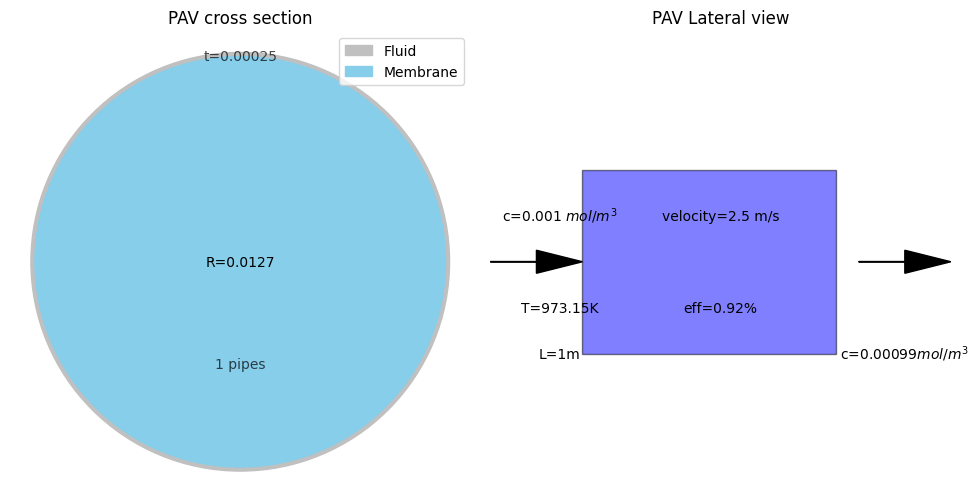

In [7]:
PAV.inspect()
PAV.plot_component()